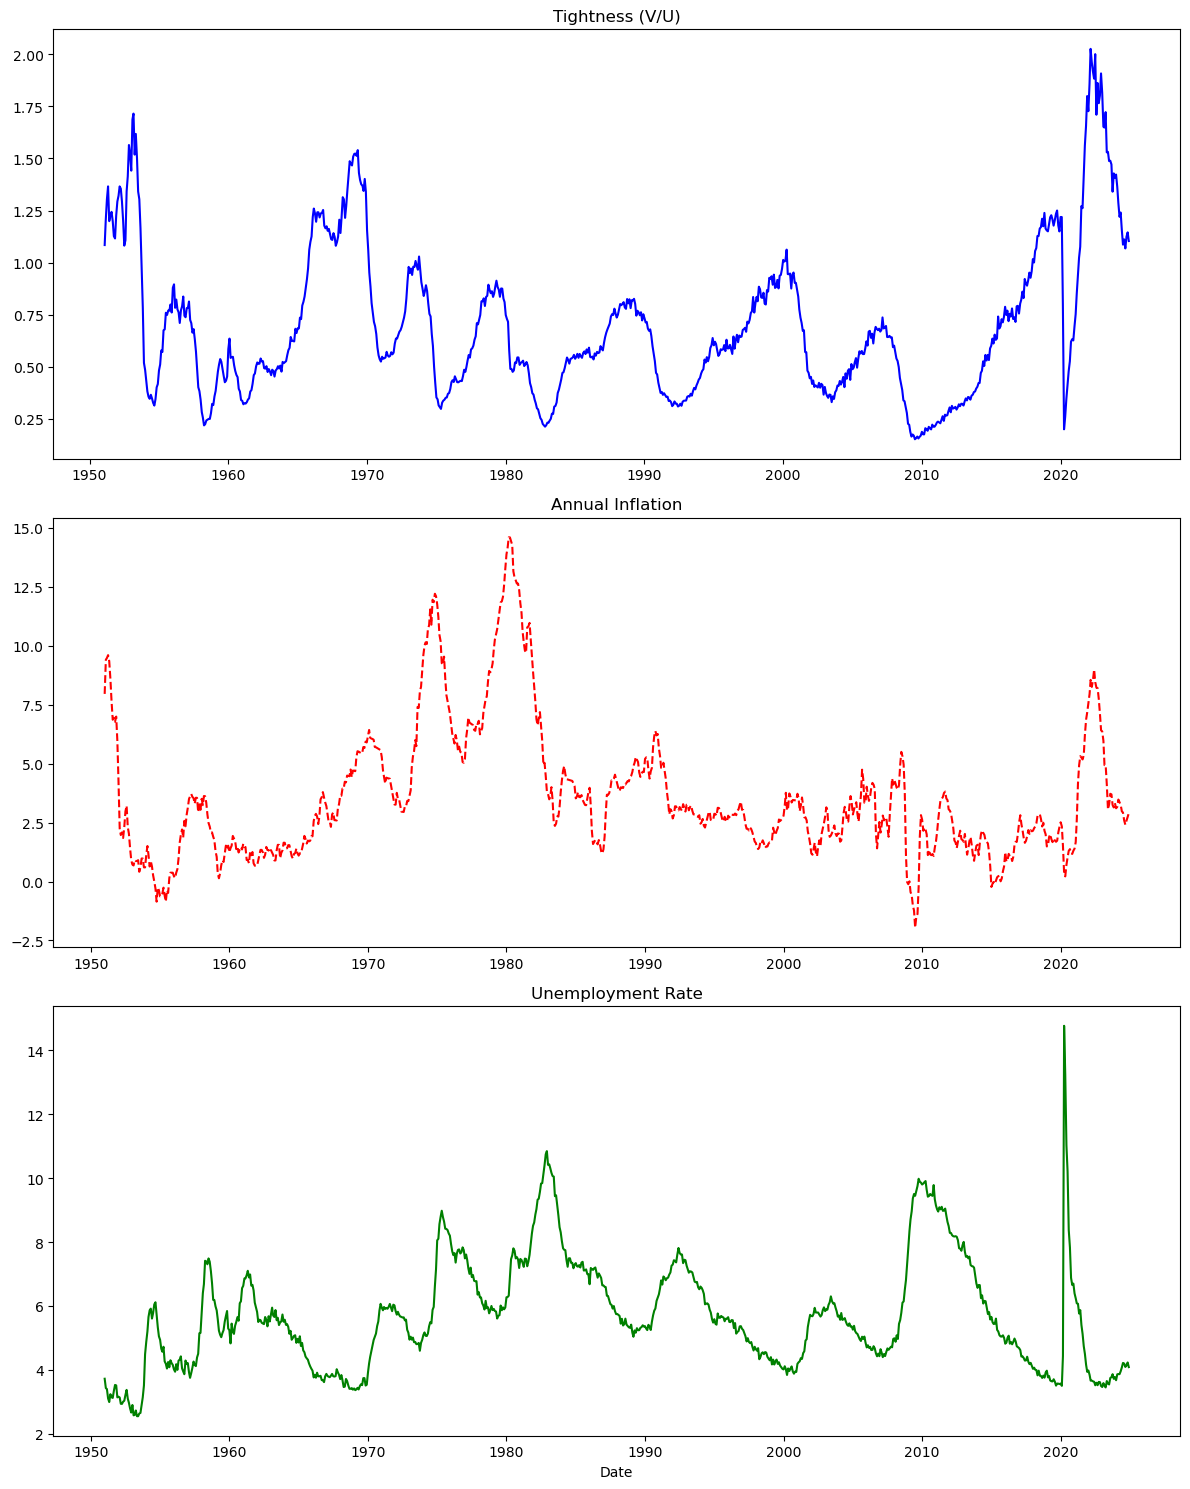

In [27]:
# Yash Singh 
# date: 10/30/24 
# Inputs: this script only takes inputs from merge_1 - which gives us the cleaned historical datastes 
# Outputs: this scripts outputs several figures and regression results related to section 6 of the paper 

# specify your outputs diretory 
output_dir = "C:/Users/singhy/Desktop/Chicago/cps_data/inflation/output"

# Necessary Packages 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm

# dataset 
data = pd.read_csv(f"{output_dir}/data/historical_data_feb.csv")
data['date'] = pd.to_datetime(data['date']) 


########################################################################
# Historical Time Series of Tightness, Inflation, Unemployment Rate 
########################################################################

# Create a new figure
plt.figure(figsize=(12, 15))

# Plot Tightness
plt.subplot(3, 1, 1)  # 3 rows, 1 column, 1st subplot
plt.plot(data['date'], data['tightness'], linestyle='-', color='b')
plt.title('Tightness (V/U)')

# Plot Inflation
plt.subplot(3, 1, 2)  # 3 rows, 1 column, 2nd subplot
plt.plot(data['date'], data['P_12m_change'], linestyle='--', color='r')
plt.title('Annual Inflation')

# Plot Unemployment Rate
plt.subplot(3, 1, 3)  # 3 rows, 1 column, 3rd subplot
plt.plot(data['date'], data['U_rate'], linestyle='-', color='g')
plt.xlabel('Date')
plt.title('Unemployment Rate')

# Adjust layout
plt.tight_layout()
plt.savefig(f"{output_dir}/figures/historical_time_series.pdf", format='pdf')
plt.show()

########################################################################
# Historical Regressions 
########################################################################

# Specify Time period - All our regression will be pre pandemic for now 
reg_data = data[(data['date'] >= '1951-01-01') & (data['date'] <= '2019-12-01')]
reg_data = reg_data.copy()

reg_data.loc[:, 'U_rate_squared'] = reg_data['U_rate'] ** 2

def run_regression_get_latex(data, y_var, covariates):
    X = sm.add_constant(data[covariates])
    y = data[y_var]
    model = sm.OLS(y, X).fit()
    return model

# Create LaTeX table header
latex_table = """\\begin{table}[!htbp]
\\centering
\\caption{Regression Results}
\\label{tab:regressions}
\\begin{tabular}{lcccccc}
\\hline\\hline
& \\multicolumn{3}{c}{Vacancy Rate} & \\multicolumn{3}{c}{Labor Market Tightness} \\\\
\\cline{2-4} \\cline{5-7}
& (1) & (2) & (3) & (4) & (5) & (6) \\\\
\\hline
"""

# Define specifications
specs = [
    ('V_rate', ['U_rate']),
    ('V_rate', ['U_rate', 'P_12m_change']),
    ('V_rate', ['U_rate', 'U_rate_squared', 'P_12m_change']),
    ('tightness', ['U_rate']),
    ('tightness', ['U_rate', 'P_12m_change']),
    ('tightness', ['U_rate', 'U_rate_squared', 'P_12m_change'])
]

# Run all models and store results
models = [run_regression_get_latex(reg_data, y_var, covs) for y_var, covs in specs]

# Function to format coefficient with stars
def format_coef(coef, pval):
    coef_str = f"{coef:0.3f}"
    if pval < 0.01:
        coef_str += "^{***}"
    elif pval < 0.05:
        coef_str += "^{**}"
    elif pval < 0.1:
        coef_str += "^{*}"
    return coef_str

# Add coefficients to table
variables = ['Unemployment Rate', 'Inflation', 'Unemployment Rate$^2$', 'Constant']
var_mapping = {
    'U_rate': 'Unemployment Rate',
    'P_12m_change': 'Inflation',
    'U_rate_squared': 'Unemployment Rate$^2$',
    'const': 'Constant'
}

for var in ['U_rate', 'P_12m_change', 'U_rate_squared', 'const']:
    row = f"{var_mapping[var]} & "
    for model in models:
        if var in model.params:
            coef = format_coef(model.params[var], model.pvalues[var])
            se = f"({model.bse[var]:0.3f})"
            row += f"${coef}$ & "
            row += f"{se} & "
        else:
            row += "& & "
    row = row[:-2] + "\\\\"
    latex_table += row + "\n"

# Add R-squared and N
latex_table += "\\hline\n"
r2_row = "R$^2$ & "
n_row = "Observations & "
for model in models:
    r2_row += f"{model.rsquared:0.3f} & "
    n_row += f"{int(model.nobs)} & "
r2_row = r2_row[:-2] + "\\\\\n"
n_row = n_row[:-2] + "\\\\\n"
latex_table += r2_row
latex_table += n_row

# Add table footer
latex_table += """\\hline\\hline
\\multicolumn{7}{l}{\\textit{Note:} Standard errors in parentheses} \\\\
\\multicolumn{7}{l}{*** p$<$0.01, ** p$<$0.05, * p$<$0.1} \\\\
\\end{tabular}
\\end{table}"""

with open(f"{output_dir}/tables/us_historical_regressions.tex", "w") as file:
    file.write(latex_table)


In [28]:
reg_data

,date,P_12m_change,V,U,U_rate,V_rate,tightness,ln_tightness,U_rate_squared
0,1951-01-01,7.954062,NaN,2305.0,3.721283,NaN,NaN,NaN,13.847948
1,1951-02-01,9.402795,2295.689006,2117.0,3.426786,3.716030,1.084407,0.081033,11.742864
2,1951-03-01,9.475465,2554.677439,2125.0,3.398586,4.085784,1.202201,0.184154,11.550388
3,1951-04-01,9.598309,2502.487739,1919.0,3.104776,4.048809,1.304058,0.265481,9.639635
4,1951-05-01,9.339504,2534.983959,1856.0,2.991425,4.085784,1.365832,0.311764,8.948626
...,...,...,...,...,...,...,...,...,...
823,2019-08-01,1.737641,7150.000000,5945.0,3.630002,4.365772,1.202691,0.184562,13.176917
824,2019-09-01,1.684498,7100.000000,5753.0,3.505960,4.326841,1.234139,0.210373,12.291756
825,2019-10-01,1.733974,7340.000000,5871.0,3.570820,4.464286,1.250213,0.223314,12.750758
826,2019-11-01,2.092290,6915.000000,5868.0,3.567238,4.203724,1.178425,0.164179,12.725189


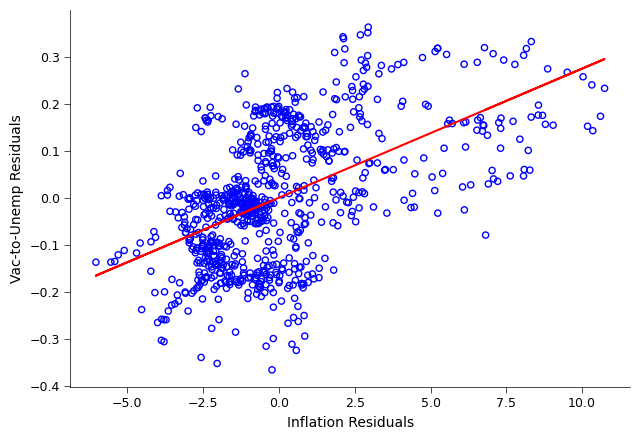

In [30]:
# Residualizing Inflation 
inflation_vars = ['U_rate', 'U_rate_squared', 'P_12m_change']
subset_infl = reg_data[inflation_vars].dropna()
X = sm.add_constant(subset_infl[['U_rate', 'U_rate_squared']])  
y = subset_infl['P_12m_change'] 
model = sm.OLS(y, X).fit()
reg_data.loc[subset_infl.index, 'inflation_residuals'] = model.resid

# Residualizing Tightness
tightness_vars = ['U_rate', 'U_rate_squared', 'tightness']
subset_tight = reg_data[tightness_vars].dropna()
X = sm.add_constant(subset_tight[['U_rate', 'U_rate_squared']])  
y = subset_tight['tightness'] 
model = sm.OLS(y, X).fit()
reg_data.loc[subset_tight.index, 'tightness_residuals'] = model.resid

# Stick to the original structure; just fix the residual alignment issue

# Set figure style for AER
plt.style.use('default')
fig, ax = plt.subplots(figsize=(6.5, 4.5))  # AER typically uses smaller figures

# Drop rows where either residual is missing
resid_data = reg_data[['inflation_residuals', 'tightness_residuals']].dropna()

# Create scatter plot with blue outlines and no fill
ax.scatter(resid_data['inflation_residuals'], 
           resid_data['tightness_residuals'], 
           edgecolor='blue',  # Outline color
           facecolor='none',  # No fill color
           s=20)  # Smaller point size

# Calculate and add regression line in red
x = resid_data['inflation_residuals']
y = resid_data['tightness_residuals']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax.plot(x, p(x), color='red', linewidth=1.5)  # Regression line in red

# Customize axes and labels
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

# Set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Add labels with proper formatting
ax.set_xlabel('Inflation Residuals', fontsize=10)
ax.set_ylabel('Vac-to-Unemp Residuals', fontsize=10)

# Remove grid
ax.grid(False)

# Set tick parameters
ax.tick_params(direction='out', length=4, width=0.5, labelsize=9)

# Adjust layout
plt.tight_layout()
plt.show()


In [14]:
reg_data


,date,P_12m_change,V,U,U_rate,V_rate,tightness,ln_tightness,U_rate_squared,inflation_residuals,tightness_residuals
0,1951-01-01,7.954062,NaN,2305.0,3.721283,NaN,NaN,NaN,13.847948,5.193223,NaN
1,1951-02-01,9.402795,2295.689006,2117.0,3.426786,3.716030,1.084407,0.081033,11.742864,6.816884,NaN
2,1951-03-01,9.475465,2554.677439,2125.0,3.398586,4.085784,1.202201,0.184154,11.550388,6.906855,NaN
3,1951-04-01,9.598309,2502.487739,1919.0,3.104776,4.048809,1.304058,0.265481,9.639635,7.215658,NaN
4,1951-05-01,9.339504,2534.983959,1856.0,2.991425,4.085784,1.365832,0.311764,8.948626,7.031383,NaN
...,...,...,...,...,...,...,...,...,...,...,...
823,2019-08-01,1.737641,7150.000000,5945.0,3.630002,4.365772,1.202691,0.184562,13.176917,-0.970098,NaN
824,2019-09-01,1.684498,7100.000000,5753.0,3.505960,4.326841,1.234139,0.210373,12.291756,-0.949471,NaN
825,2019-10-01,1.733974,7340.000000,5871.0,3.570820,4.464286,1.250213,0.223314,12.750758,-0.938801,NaN
826,2019-11-01,2.092290,6915.000000,5868.0,3.567238,4.203724,1.178425,0.164179,12.725189,-0.578354,NaN


In [ ]:
reg_data